In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

import os
import sys
from copy import deepcopy

# Add src to path
sys.path.append("src")
from BWImage import BWImage
from utils import get_gaussian_kernel
from utils import convolve
from utils import convolve_pixel


## Jupyter notebooks settings.

# Reload modules before executing each cell.
%load_ext autoreload
%autoreload 2 

# Print all print statements.
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all" 

# Set white as color for pixels with no value.
BWImage.blank_value = 0

# Introduction

In this lab we blur an input image by applying a Gaussian kernel with spatially-variable $\sigma$.

## Theory

### Question-1
#### Obtain the expression for $\sigma$

In #1 we are given an expression for $\sigma$ and here $A$ and $B$ are unknown. One could take $\log$ on both side and convert this a system of linear equations with two unknowns and solve it to obtain the values of $A$ and $B$.

Also, the given values are such that they could be easily calculated with a calculator. I use both approach to solve.

#### Perform space-variant blurring
Given sigma for a pixel location, I create a Gaussian kernel for that location. Similar to lab-4, I seperated the Gaussian kernel and did convolution in different order for better computational efficiency.

For convenience, I copy paste the approach from lab-4 below.
Gaussian kernel is a matrix $M$ such that, $M = M / \sum_{i, j}M'_{i, j}$, where $M'_{x,y} = e^{-\frac{x^2 + y^2}{2\sigma}}$. 
The kernel has a dimension $k$, where $k = k'$ if $k'$ is odd and $k = k' + 1$ if k is even and $k' = \lceil{6\sigma + 1}\rceil$. Note that I have ignored the constants in the Gaussian function as we are normalizing the values.

Instead of using an $k \times k$ Gaussian kernel, I seperated the Gaussian kernels for computational efficiency. This possible because Gaussian kernel is a seperable kernel, i.e., $M = vv^T$, where $v = v'/\sum_{i}v'_i$, and where $v' = e ^{-x^2/2\sigma}$. We can see that $M_{x, y} = v_xv^T_y$ and therefore $M = vv^T$.

### Question-2

For #2, I use the same code for space-variant blurring, except I switch the function to obtain $\sigma$ based on expression in #1 to one where it returns a constant $1.0$.

## Implementation.
**Input**: `data/input`

**Output**: `data/output`

**Source code**: `src`

* `BWImage.py`: Same from my previous labs. Implements a class with methods for basic image I/O.

* `utils.py`: Contains functions important to this lab. 
    - The `get_gaussian_kernel` function takes as input a $\sigma$ value and gives the $v$ described above. Same as lab-4.
    - The `convolve` function takes as input a image in BWImage format and $v$ and returns convolved image. Same as lab-4.
    - Unlike the `convolve` function above, the `convolve_pixel` function takes as input the pixel location in addition to the image and filter and return the intensity value of the pixel after convolution with the filter.

* `get_sigma`: Function to calculate sigma. There are 

## 1. Space-variant blurring

In [2]:
# Read input image.
img = cv.imread('data/input/globe.png')
bwimg = BWImage(img)
N = img.shape[0]

In [3]:
## Define sigma for Q1.
def get_r(m, n):
    return ((m - N / 2)**2 + (n - N / 2)**2)

def get_sigma(m, n, A, B):
    ''' 
    Sigma for Q1.
    '''
    return A * np.exp(-1 * get_r(m, n)/B)

### Solve for A and B

By taking log on the distribution of $\sigma$ we get
$$\ln(\sigma(m, n)) = \ln(A) + \frac{-r(m, n)}{B}$$
where $r = (m - N/2)^2 + (n - N/2)^2$.

We are also give the value of $\sigma$ for two different lcoations. This gives rise to a system of linear equation which can be solved to the get the values of $A$ and $B$.

Another way to solve is we can see that for $(m, n) = (N / 2, N / 2)$, we have $2 = A e^0 = A$. From this we have $A = 2$
Using this with the second condition gives $B = (-2 \times (N/ 2)^2)\ln(0.005)$. In this image $N = 195$, substituting this we get the same $B$.

In [4]:
## Solve the system of linear equations
coeffs = np.array([[1, -1 * get_r(N/2, N/2)], [1, -1 * get_r(0, 0)]])
consts = np.array([np.log(2), np.log(0.01)])
x, y = np.linalg.solve(coeffs, consts)
A = np.exp(x)
B = 1/y
print("Values of A and B: ", A, B)

Values of A and B:  2.0 3588.403390110064


In [5]:
# Solve for A and B by hand calculation.
# A = 2.0
# B = (-2 * (N / 2)**2) / np.log(0.005)
print("Values of A and B: ", A, B)

Values of A and B:  2.0 3588.403390110064


### Perform space-variant blurring

In [6]:
bwimg_blur = deepcopy(bwimg)
bwimg_blur.make_blank()
for i in range(N):
    for j in range(N):
        sigma = get_sigma(i, j, A, B)
        kernel = get_gaussian_kernel(sigma)
        bwimg_blur[i, j] = convolve_pixel((i, j), bwimg, kernel)

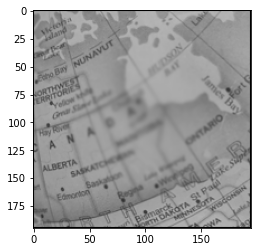

In [7]:
plt.imshow(bwimg_blur.get_image())
plt.savefig('data/output/globe_blur.png', facecolor='white')

## 2. Blur Nautilus

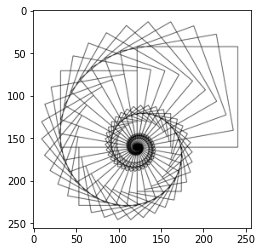

In [8]:
img = cv.imread('data/input/nautilus.png')
bwimg = BWImage(img)
N = img.shape[0]
plt.imshow(img)

In [9]:
space_invariant_kernel = get_gaussian_kernel(1.0)
bwimg_blur_space_invariant = convolve(bwimg, space_invariant_kernel)

100%|██████████| 250/250 [00:00<00:00, 473.43it/s]


In [10]:
# Change sigma definition for Q2.
def get_sigma(m, n, A, B):
    return 1.0

bwimg_blur_space_variant = deepcopy(bwimg)
bwimg_blur_space_variant.make_blank()
for i in range(N):
    for j in range(N):
        sigma = get_sigma(i, j, A, B)
        kernel = get_gaussian_kernel(sigma)
        # Use offset to translate to match the coordinates of two images
        # arising from space-variant blurring and space-invariant blurring.
        offset = int(kernel.shape[0] // 2)
        bwimg_blur_space_variant[i, j] = convolve_pixel((i + offset, j + offset), bwimg, kernel)

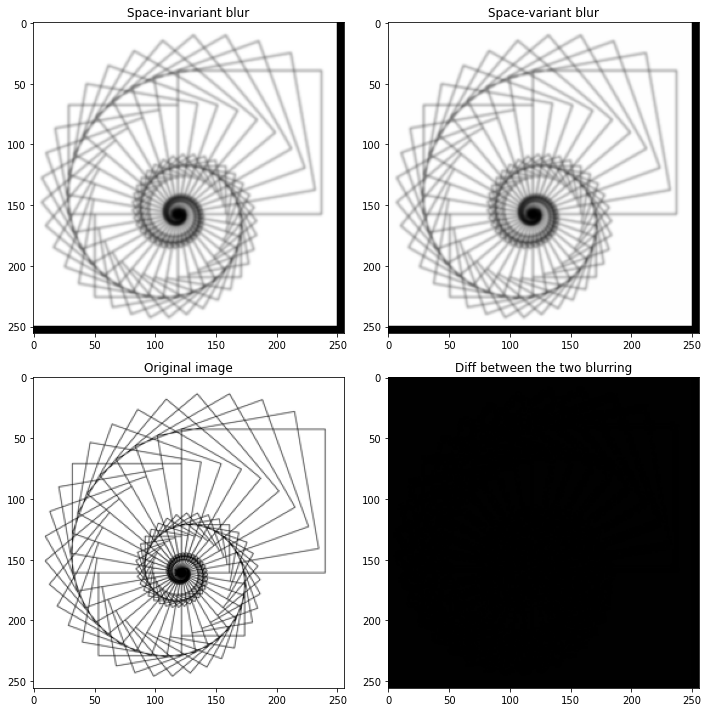

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(bwimg_blur_space_invariant.get_image())
ax[0, 0].set_title('Space-invariant blur')
ax[0, 1].imshow(bwimg_blur_space_variant.get_image())
ax[0, 1].set_title('Space-variant blur')
ax[1, 0].imshow(img)
ax[1, 0].set_title('Original image')
ax[1, 1].imshow(np.abs(bwimg_blur_space_invariant.get_image() - bwimg_blur_space_variant.get_image()))
ax[1, 1].set_title('Diff between the two blurring')
fig.tight_layout()
fig.savefig('data/output/nautilus_blur.png', facecolor='white')